# 🛞 ToyTire-3Comp Dataset Generator (v7)

Dataset synthétique avec **3 composants** - Épure de pneu en coupe :
- **carcass** : forme d'"ampoule" avec extrémités arrondies
- **crown** : couronne qui enveloppe le haut (+ sculptures optionnelles)
- **flanks** : flancs triangulaires (épais→fin)

## Nouveautés v7 :
- ✅ Extrémités de la carcasse arrondies (bouche de vase)
- ✅ Option `add_tread` pour sculptures sur la couronne
- ✅ Contrainte : `thickness_carcass <= thickness_crown`
- ✅ Classe `TireGeometryMetrics` pour évaluer les générations

## 1. Imports

In [1]:
!pip install -q numpy pandas matplotlib scipy scikit-image tqdm

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy import ndimage
from scipy.ndimage import binary_erosion, binary_dilation
from pathlib import Path
from tqdm import tqdm
from dataclasses import dataclass
from typing import Dict, Tuple, Optional, List
import warnings
warnings.filterwarnings('ignore')

try:
    from google.colab import drive
    IN_COLAB = True
    print("Running in Google Colab")
except ImportError:
    IN_COLAB = False
    print("Running locally")

Running in Google Colab


## 2. Configuration

In [3]:
CONFIG = {
    "n_samples": 1000,
    "resolution": 64,
    "seed": 42,
    "train_ratio": 0.7,
    "val_ratio": 0.15,
    "test_ratio": 0.15,
    
    # Géométrie
    "y_top_range": [6, 12],
    "y_bottom_range": [52, 58],
    
    # Largeurs
    "w_belly_range": [20, 28],
    "w_bottom_range": [10, 18],
    
    # Position du ventre
    "belly_position_range": [0.30, 0.50],
    
    # Épaisseurs (carcass <= crown, enforced)
    "thickness_carcass_range": [3, 5],
    "thickness_crown_range": [4, 7],
    "thickness_flanks_bottom_range": [1, 3],
    
    # Arrondi des extrémités
    "lip_rounding_range": [2, 4],  # Rayon d'arrondi en bas
    
    # Sculptures (tread)
    "add_tread": False,  # Par défaut désactivé
    "tread_height_range": [2, 4],
    "tread_width_range": [3, 5],
    "tread_spacing_range": [2, 4],
    "n_tread_blocks_range": [4, 8],
}

## 3. Génération des composants

### Forme de la carcasse avec extrémités arrondies :

```
         ╭───────╮          ← Arc arrondi (ellipse)
        ╱         ╲
       ╱           ╲        
      │             │       ← Ventre
      │             │
       ╲           ╱        
        ╲         ╱
         ╰╮     ╭╯          ← Extrémités ARRONDIES (comme bouche de vase)
```

In [4]:
def generate_components(resolution, y_top, y_bottom, 
                        w_belly, w_bottom,
                        belly_position, 
                        thickness_carcass, thickness_crown,
                        thickness_flanks_bottom,
                        lip_rounding=3,
                        add_tread=False,
                        tread_height=3,
                        tread_width=4,
                        tread_spacing=3,
                        n_tread_blocks=6):
    """
    Génère les 3 composants avec :
    - Carcasse en forme d'ampoule avec extrémités arrondies
    - Couronne enveloppante (+ sculptures optionnelles)
    - Flancs triangulaires
    
    Parameters:
    -----------
    lip_rounding : int
        Rayon d'arrondi pour les extrémités de la carcasse
    add_tread : bool
        Si True, ajoute des sculptures rectangulaires sur la couronne
    tread_height, tread_width, tread_spacing, n_tread_blocks : int
        Paramètres des sculptures
    """
    cx = resolution // 2
    
    # Enforce constraint: thickness_carcass <= thickness_crown
    thickness_carcass = min(thickness_carcass, thickness_crown)
    
    y_belly = int(y_top + belly_position * (y_bottom - y_top))
    arc_height = y_belly - y_top
    flank_height = y_bottom - y_belly
    
    thickness_flanks_top = thickness_crown
    
    carcass = np.zeros((resolution, resolution), dtype=np.uint8)
    crown = np.zeros((resolution, resolution), dtype=np.uint8)
    flanks = np.zeros((resolution, resolution), dtype=np.uint8)
    
    # Paramètres ellipse
    ellipse_center_y = y_belly
    ellipse_rx_outer = w_belly
    ellipse_ry_outer = arc_height
    ellipse_rx_inner = max(0, w_belly - thickness_carcass)
    ellipse_ry_inner = max(0, arc_height - thickness_carcass)
    
    # Position où commence l'arrondi des lèvres
    y_lip_start = y_bottom - lip_rounding
    
    # ==================== CARCASSE ====================
    for y in range(resolution):
        if y < y_top or y > y_bottom:
            continue
        
        if y <= y_belly:
            # ===== PARTIE HAUTE : DEMI-ELLIPSE =====
            dy = y - ellipse_center_y
            
            if ellipse_ry_outer > 0:
                ratio_outer = (dy / ellipse_ry_outer) ** 2
                if ratio_outer <= 1:
                    w_outer = ellipse_rx_outer * np.sqrt(1 - ratio_outer)
                else:
                    w_outer = 0
            else:
                w_outer = ellipse_rx_outer
            
            if ellipse_ry_inner > 0 and ellipse_rx_inner > 0:
                ratio_inner = (dy / ellipse_ry_inner) ** 2
                if ratio_inner <= 1:
                    w_inner = ellipse_rx_inner * np.sqrt(1 - ratio_inner)
                else:
                    w_inner = 0
            else:
                w_inner = 0
                
        else:
            # ===== PARTIE BASSE : FLANCS + ARRONDI =====
            t = (y - y_belly) / flank_height if flank_height > 0 else 0
            t_smooth = 0.5 * (1 - np.cos(np.pi * t))
            
            w_outer_base = w_belly + t_smooth * (w_bottom - w_belly)
            w_inner_base = max(0, w_outer_base - thickness_carcass)
            
            # Arrondi des extrémités (lèvres)
            if y >= y_lip_start and lip_rounding > 0:
                # Distance depuis le début de l'arrondi
                dy_lip = y - y_lip_start
                # Courbe vers l'intérieur (arc de cercle)
                if dy_lip <= lip_rounding:
                    # Décalage qui augmente vers le bas
                    lip_curve = lip_rounding * (1 - np.sqrt(1 - (dy_lip / lip_rounding) ** 2))
                    w_outer = w_outer_base - lip_curve * 0.5  # Extérieur rentre un peu
                    w_inner = w_inner_base + lip_curve * 0.5  # Intérieur sort un peu
                else:
                    w_outer = w_outer_base
                    w_inner = w_inner_base
            else:
                w_outer = w_outer_base
                w_inner = w_inner_base
        
        # Remplir la carcasse
        for x in range(resolution):
            dist = abs(x - cx)
            if w_inner <= dist <= w_outer:
                carcass[y, x] = 1
    
    # ==================== COURONNE ====================
    crown_rx_outer = ellipse_rx_outer + thickness_crown
    crown_ry_outer = ellipse_ry_outer + thickness_crown
    crown_center_y = y_belly
    
    for y in range(resolution):
        if y > y_belly:
            continue
        
        dy = y - crown_center_y
        
        if crown_ry_outer > 0:
            ratio_crown = (dy / crown_ry_outer) ** 2
            if ratio_crown <= 1:
                w_crown_outer = crown_rx_outer * np.sqrt(1 - ratio_crown)
            else:
                continue
        else:
            w_crown_outer = crown_rx_outer
        
        if ellipse_ry_outer > 0:
            ratio_outer = (dy / ellipse_ry_outer) ** 2
            if ratio_outer <= 1:
                w_carcass_outer = ellipse_rx_outer * np.sqrt(1 - ratio_outer)
            else:
                w_carcass_outer = 0
        else:
            w_carcass_outer = ellipse_rx_outer
        
        for x in range(resolution):
            dist = abs(x - cx)
            if w_carcass_outer < dist <= w_crown_outer:
                crown[y, x] = 1
            elif dist <= w_crown_outer and carcass[y, x] == 0:
                if y < y_top + thickness_crown:
                    crown[y, x] = 1
    
    crown = crown & (~carcass).astype(np.uint8)
    
    # ==================== SCULPTURES (TREAD) ====================
    if add_tread:
        # Trouver le sommet de la couronne
        crown_rows = np.where(crown.any(axis=1))[0]
        if len(crown_rows) > 0:
            y_crown_top = crown_rows.min()
            
            # Zone de la bande de roulement (centre de la couronne)
            # Trouver la largeur au sommet
            crown_cols_top = np.where(crown[y_crown_top, :] > 0)[0]
            if len(crown_cols_top) > 0:
                x_left = crown_cols_top.min()
                x_right = crown_cols_top.max()
                tread_zone_width = x_right - x_left
                
                # Calculer positions des blocs
                total_block_width = n_tread_blocks * tread_width + (n_tread_blocks - 1) * tread_spacing
                start_x = cx - total_block_width // 2
                
                for i in range(n_tread_blocks):
                    block_x = start_x + i * (tread_width + tread_spacing)
                    
                    for dy in range(tread_height):
                        y_tread = y_crown_top - tread_height + dy
                        if y_tread < 0:
                            continue
                        for dx in range(tread_width):
                            x_tread = block_x + dx
                            if 0 <= x_tread < resolution:
                                crown[y_tread, x_tread] = 1
    
    # ==================== FLANCS ====================
    for y in range(resolution):
        if y <= y_belly or y > y_bottom:
            continue
        
        t = (y - y_belly) / flank_height if flank_height > 0 else 0
        t_smooth = 0.5 * (1 - np.cos(np.pi * t))
        
        w_carcass_outer_base = w_belly + t_smooth * (w_bottom - w_belly)
        
        # Appliquer l'arrondi des lèvres aussi pour les flancs
        if y >= y_lip_start and lip_rounding > 0:
            dy_lip = y - y_lip_start
            if dy_lip <= lip_rounding:
                lip_curve = lip_rounding * (1 - np.sqrt(1 - (dy_lip / lip_rounding) ** 2))
                w_carcass_outer = w_carcass_outer_base - lip_curve * 0.5
            else:
                w_carcass_outer = w_carcass_outer_base
        else:
            w_carcass_outer = w_carcass_outer_base
        
        current_thickness = thickness_flanks_top + t * (thickness_flanks_bottom - thickness_flanks_top)
        w_flanks_outer = w_carcass_outer + current_thickness
        
        for x in range(resolution):
            dist = abs(x - cx)
            if w_carcass_outer < dist <= w_flanks_outer:
                flanks[y, x] = 1
    
    flanks = flanks & (~carcass).astype(np.uint8) & (~crown).astype(np.uint8)
    
    full = (carcass | crown | flanks).astype(np.uint8)
    
    return {
        'carcass': carcass,
        'crown': crown,
        'flanks': flanks,
        'full': full,
        'y_belly': y_belly,
        'y_top': y_top,
        'y_bottom': y_bottom,
        'has_tread': add_tread
    }

## 4. Validation

In [5]:
def validate_components(carcass, crown, flanks):
    errors = []
    
    if (carcass & crown).sum() > 0:
        errors.append(f"Overlap carcass-crown: {(carcass & crown).sum()} px")
    if (carcass & flanks).sum() > 0:
        errors.append(f"Overlap carcass-flanks: {(carcass & flanks).sum()} px")
    if (crown & flanks).sum() > 0:
        errors.append(f"Overlap crown-flanks: {(crown & flanks).sum()} px")
    
    full = carcass | crown | flanks
    labeled, n_components = ndimage.label(full)
    if n_components != 1:
        errors.append(f"Full not connected: {n_components} components")
    
    labeled_crown, n_crown = ndimage.label(crown)
    if n_crown != 1:
        errors.append(f"Crown not connected: {n_crown} components")
    
    min_area = 50
    if carcass.sum() < min_area:
        errors.append(f"Carcass too small: {carcass.sum()} px")
    if crown.sum() < min_area:
        errors.append(f"Crown too small: {crown.sum()} px")
    if flanks.sum() < min_area:
        errors.append(f"Flanks too small: {flanks.sum()} px")
    
    return len(errors) == 0, errors

## 5. Classe TireGeometryMetrics

### Description

Cette classe évalue à quel point des images générées (par un modèle génératif comme la diffusion) respectent la géométrie attendue d'une épure de pneu.

### Métriques calculées :

| Métrique | Description | Plage | Idéal |
|----------|-------------|-------|-------|
| `overlap_score` | Absence de chevauchement entre composants | [0, 1] | 1.0 |
| `connectivity_score` | Union forme un seul blob connecté | [0, 1] | 1.0 |
| `component_connectivity` | Chaque composant est un seul blob | [0, 1] | 1.0 |
| `symmetry_score` | Symétrie par rapport à l'axe vertical | [0, 1] | 1.0 |
| `ellipse_fit_score` | Conformité du haut à une forme elliptique | [0, 1] | 1.0 |
| `vertical_ordering_score` | Crown en haut, flanks en bas | [0, 1] | 1.0 |
| `area_ratio_score` | Ratios d'aires dans les plages attendues | [0, 1] | 1.0 |
| `thickness_consistency_score` | Épaisseur cohérente le long du profil | [0, 1] | 1.0 |
| **`global_score`** | **Moyenne pondérée de toutes les métriques** | [0, 1] | 1.0 |

### Utilisation :
```python
metrics = TireGeometryMetrics()
scores = metrics.evaluate(carcass, crown, flanks)
print(f"Global score: {scores['global_score']:.3f}")
```

In [6]:
@dataclass
class TireGeometryMetrics:
    """
    Évalue la conformité géométrique d'images de composants de pneu générées.
    
    Cette classe est conçue pour évaluer les sorties de modèles génératifs
    (diffusion, VAE, GAN, etc.) en mesurant à quel point les images générées
    respectent les contraintes géométriques d'une épure de pneu valide.
    
    Attributes:
    -----------
    weights : dict
        Poids pour chaque métrique dans le score global
    expected_area_ratios : dict
        Ratios d'aires attendus pour chaque composant
    """
    
    # Poids par défaut pour le score global
    weights: Dict[str, float] = None
    
    # Ratios d'aires attendus (basés sur les données générées)
    expected_area_ratios: Dict[str, Tuple[float, float]] = None
    
    def __post_init__(self):
        if self.weights is None:
            self.weights = {
                'overlap_score': 0.20,          # Très important : pas de chevauchement
                'connectivity_score': 0.15,      # Important : blob unique
                'component_connectivity': 0.10,  # Chaque composant connecté
                'symmetry_score': 0.10,          # Symétrie
                'ellipse_fit_score': 0.15,       # Forme elliptique du haut
                'vertical_ordering_score': 0.10, # Crown en haut, flanks en bas
                'area_ratio_score': 0.10,        # Ratios d'aires corrects
                'thickness_consistency_score': 0.10  # Épaisseur cohérente
            }
        
        if self.expected_area_ratios is None:
            self.expected_area_ratios = {
                'carcass': (0.35, 0.65),  # 35-65% de l'aire totale
                'crown': (0.15, 0.40),     # 15-40%
                'flanks': (0.10, 0.30)     # 10-30%
            }
    
    def evaluate(self, carcass: np.ndarray, crown: np.ndarray, 
                 flanks: np.ndarray) -> Dict[str, float]:
        """
        Évalue les composants générés et retourne les scores.
        
        Parameters:
        -----------
        carcass : np.ndarray
            Image binaire du composant carcasse (H, W)
        crown : np.ndarray
            Image binaire du composant couronne (H, W)
        flanks : np.ndarray
            Image binaire du composant flancs (H, W)
            
        Returns:
        --------
        Dict[str, float]
            Dictionnaire avec toutes les métriques et le score global
        """
        # Binariser si nécessaire
        carcass = (carcass > 0.5).astype(np.uint8)
        crown = (crown > 0.5).astype(np.uint8)
        flanks = (flanks > 0.5).astype(np.uint8)
        
        full = carcass | crown | flanks
        
        scores = {}
        
        # 1. Score de non-chevauchement
        scores['overlap_score'] = self._compute_overlap_score(carcass, crown, flanks)
        
        # 2. Score de connectivité globale
        scores['connectivity_score'] = self._compute_connectivity_score(full)
        
        # 3. Score de connectivité par composant
        scores['component_connectivity'] = self._compute_component_connectivity(
            carcass, crown, flanks)
        
        # 4. Score de symétrie
        scores['symmetry_score'] = self._compute_symmetry_score(full)
        
        # 5. Score de conformité elliptique
        scores['ellipse_fit_score'] = self._compute_ellipse_fit_score(carcass, crown)
        
        # 6. Score d'ordonnancement vertical
        scores['vertical_ordering_score'] = self._compute_vertical_ordering_score(
            carcass, crown, flanks)
        
        # 7. Score des ratios d'aires
        scores['area_ratio_score'] = self._compute_area_ratio_score(
            carcass, crown, flanks)
        
        # 8. Score de cohérence d'épaisseur
        scores['thickness_consistency_score'] = self._compute_thickness_consistency(
            carcass)
        
        # Score global pondéré
        scores['global_score'] = sum(
            self.weights[k] * scores[k] for k in self.weights
        )
        
        return scores
    
    def _compute_overlap_score(self, carcass, crown, flanks) -> float:
        """
        Calcule le score de non-chevauchement.
        Score = 1 si aucun chevauchement, décroît avec les pixels qui se chevauchent.
        """
        overlap_cc = (carcass & crown).sum()
        overlap_cf = (carcass & flanks).sum()
        overlap_crfl = (crown & flanks).sum()
        
        total_overlap = overlap_cc + overlap_cf + overlap_crfl
        total_area = carcass.sum() + crown.sum() + flanks.sum()
        
        if total_area == 0:
            return 0.0
        
        # Pénalité exponentielle pour les chevauchements
        overlap_ratio = total_overlap / total_area
        return np.exp(-10 * overlap_ratio)
    
    def _compute_connectivity_score(self, full) -> float:
        """
        Vérifie si l'union forme un seul composant connecté.
        """
        if full.sum() == 0:
            return 0.0
        
        labeled, n_components = ndimage.label(full)
        
        if n_components == 1:
            return 1.0
        elif n_components == 0:
            return 0.0
        else:
            # Pénalité pour composants multiples
            # Mesurer la taille du plus grand composant
            component_sizes = ndimage.sum(full, labeled, range(1, n_components + 1))
            largest = max(component_sizes)
            return largest / full.sum()
    
    def _compute_component_connectivity(self, carcass, crown, flanks) -> float:
        """
        Vérifie que chaque composant est un seul blob connecté.
        """
        scores = []
        
        for comp in [carcass, crown, flanks]:
            if comp.sum() == 0:
                scores.append(0.0)
                continue
            
            labeled, n = ndimage.label(comp)
            if n == 1:
                scores.append(1.0)
            else:
                component_sizes = ndimage.sum(comp, labeled, range(1, n + 1))
                largest = max(component_sizes)
                scores.append(largest / comp.sum())
        
        return np.mean(scores)
    
    def _compute_symmetry_score(self, full) -> float:
        """
        Mesure la symétrie par rapport à l'axe vertical central.
        """
        if full.sum() == 0:
            return 0.0
        
        flipped = np.fliplr(full)
        intersection = (full & flipped).sum()
        union = (full | flipped).sum()
        
        if union == 0:
            return 0.0
        
        return intersection / union  # IoU avec version miroir
    
    def _compute_ellipse_fit_score(self, carcass, crown) -> float:
        """
        Évalue si le haut de la forme suit bien une courbe elliptique.
        Utilise le ratio périmètre²/aire qui devrait être proche de 4π pour un cercle.
        """
        top_region = carcass | crown
        
        if top_region.sum() == 0:
            return 0.0
        
        # Trouver le centre de masse
        rows = np.where(top_region.any(axis=1))[0]
        if len(rows) == 0:
            return 0.0
        
        y_center = rows.mean()
        
        # Prendre seulement la partie haute (au-dessus du centre)
        top_half = top_region.copy()
        top_half[int(y_center):, :] = 0
        
        if top_half.sum() < 10:
            return 0.5  # Pas assez de pixels pour évaluer
        
        # Calculer le contour
        eroded = binary_erosion(top_half)
        contour = top_half.astype(int) - eroded.astype(int)
        perimeter = contour.sum()
        area = top_half.sum()
        
        if perimeter == 0:
            return 0.0
        
        # Circularité = 4π * aire / périmètre²
        # Pour un cercle parfait = 1, pour une ellipse ≈ 0.8-1
        circularity = 4 * np.pi * area / (perimeter ** 2)
        
        # Score basé sur la circularité (valeurs entre 0.5 et 1 sont bonnes)
        if circularity > 1:
            circularity = 1 / circularity  # Normaliser
        
        return min(1.0, circularity / 0.7)  # 0.7 est une bonne valeur pour ellipse
    
    def _compute_vertical_ordering_score(self, carcass, crown, flanks) -> float:
        """
        Vérifie que crown est en haut et flanks en bas.
        """
        def get_center_y(comp):
            if comp.sum() == 0:
                return None
            rows = np.where(comp.any(axis=1))[0]
            return rows.mean()
        
        y_crown = get_center_y(crown)
        y_carcass = get_center_y(carcass)
        y_flanks = get_center_y(flanks)
        
        if any(y is None for y in [y_crown, y_carcass, y_flanks]):
            return 0.0
        
        # Crown devrait être plus haut (y plus petit) que carcass et flanks
        # Flanks devrait être plus bas que carcass
        score = 0.0
        
        if y_crown < y_carcass:
            score += 0.5
        if y_carcass < y_flanks:
            score += 0.5
        
        return score
    
    def _compute_area_ratio_score(self, carcass, crown, flanks) -> float:
        """
        Vérifie que les ratios d'aires sont dans les plages attendues.
        """
        total = carcass.sum() + crown.sum() + flanks.sum()
        
        if total == 0:
            return 0.0
        
        ratios = {
            'carcass': carcass.sum() / total,
            'crown': crown.sum() / total,
            'flanks': flanks.sum() / total
        }
        
        scores = []
        for name, ratio in ratios.items():
            min_r, max_r = self.expected_area_ratios[name]
            if min_r <= ratio <= max_r:
                scores.append(1.0)
            else:
                # Distance à la plage
                if ratio < min_r:
                    dist = min_r - ratio
                else:
                    dist = ratio - max_r
                scores.append(max(0, 1 - dist * 5))
        
        return np.mean(scores)
    
    def _compute_thickness_consistency(self, carcass) -> float:
        """
        Mesure la cohérence de l'épaisseur de la carcasse.
        Une bonne carcasse a une épaisseur relativement constante.
        """
        if carcass.sum() == 0:
            return 0.0
        
        # Calculer l'épaisseur par ligne
        thickness_per_row = carcass.sum(axis=1)
        active_rows = thickness_per_row > 0
        
        if active_rows.sum() < 5:
            return 0.5
        
        thicknesses = thickness_per_row[active_rows]
        
        # Coefficient de variation (std / mean)
        cv = thicknesses.std() / thicknesses.mean() if thicknesses.mean() > 0 else 1
        
        # Score inversement proportionnel à la variation
        # CV < 0.3 est bon, > 0.6 est mauvais
        return max(0, 1 - cv)
    
    def evaluate_batch(self, carcass_batch: np.ndarray, crown_batch: np.ndarray,
                       flanks_batch: np.ndarray) -> Dict[str, np.ndarray]:
        """
        Évalue un batch d'images.
        
        Parameters:
        -----------
        carcass_batch : np.ndarray
            Batch de carcasses (N, H, W) ou (N, 1, H, W)
        crown_batch : np.ndarray
            Batch de couronnes
        flanks_batch : np.ndarray
            Batch de flancs
            
        Returns:
        --------
        Dict[str, np.ndarray]
            Métriques pour chaque échantillon
        """
        # Gérer les différentes formes d'entrée
        if len(carcass_batch.shape) == 4:
            carcass_batch = carcass_batch.squeeze(1)
            crown_batch = crown_batch.squeeze(1)
            flanks_batch = flanks_batch.squeeze(1)
        
        n_samples = len(carcass_batch)
        
        all_scores = {}
        
        for i in range(n_samples):
            scores = self.evaluate(
                carcass_batch[i],
                crown_batch[i],
                flanks_batch[i]
            )
            
            for key, value in scores.items():
                if key not in all_scores:
                    all_scores[key] = []
                all_scores[key].append(value)
        
        return {k: np.array(v) for k, v in all_scores.items()}
    
    def summary(self, scores: Dict[str, float]) -> str:
        """
        Génère un résumé textuel des scores.
        """
        lines = ["=" * 50]
        lines.append("TIRE GEOMETRY METRICS SUMMARY")
        lines.append("=" * 50)
        
        for key, value in scores.items():
            if key == 'global_score':
                continue
            status = "✓" if value >= 0.8 else "⚠" if value >= 0.5 else "✗"
            lines.append(f"{status} {key:30s}: {value:.3f}")
        
        lines.append("-" * 50)
        gs = scores['global_score']
        status = "✓" if gs >= 0.8 else "⚠" if gs >= 0.5 else "✗"
        lines.append(f"{status} {'GLOBAL SCORE':30s}: {gs:.3f}")
        lines.append("=" * 50)
        
        return "\n".join(lines)

## 6. Métriques additionnelles

In [7]:
def compute_metrics(carcass, crown, flanks):
    """Calcule les métriques géométriques standard."""
    full = carcass | crown | flanks
    
    rows = np.where(full.any(axis=1))[0]
    cols = np.where(full.any(axis=0))[0]
    
    if len(rows) == 0 or len(cols) == 0:
        return None
    
    height_px = rows.max() - rows.min() + 1
    width_px = cols.max() - cols.min() + 1
    aspect_ratio_px = height_px / width_px if width_px > 0 else 0
    
    area_full = full.sum()
    area_carcass = carcass.sum()
    area_crown = crown.sum()
    area_flanks = flanks.sum()
    
    return {
        'height_px': height_px,
        'width_px': width_px,
        'aspect_ratio_px': aspect_ratio_px,
        'area_full': area_full,
        'area_carcass': area_carcass,
        'area_crown': area_crown,
        'area_flanks': area_flanks,
        'carcass_to_full': area_carcass / area_full if area_full > 0 else 0,
        'crown_to_full': area_crown / area_full if area_full > 0 else 0,
        'flanks_to_full': area_flanks / area_full if area_full > 0 else 0,
    }

## 7. Visualisation

In [8]:
def visualize_sample(components, title="Sample"):
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    
    for idx, (name, cmap) in enumerate([('carcass', 'Reds'), 
                                         ('crown', 'Blues'), 
                                         ('flanks', 'Greens'),
                                         ('full', 'gray')]):
        ax = axes[idx // 3, idx % 3]
        ax.imshow(components[name], cmap=cmap, origin='upper', vmin=0, vmax=1)
        ax.set_title(f"{name} ({components[name].sum()} px)")
        ax.axis('off')
        if 'y_belly' in components:
            ax.axhline(y=components['y_belly'], color='yellow', linestyle='--', alpha=0.5)
    
    ax = axes[1, 1]
    resolution = components['carcass'].shape[0]
    overlay = np.zeros((resolution, resolution, 3))
    
    colors = {
        'carcass': [0.9, 0.2, 0.2],
        'crown': [0.2, 0.5, 0.9],
        'flanks': [0.2, 0.8, 0.3]
    }
    
    for name, color in colors.items():
        mask = components[name] > 0
        for c in range(3):
            overlay[:, :, c] += mask * color[c]
    
    ax.imshow(overlay, origin='upper')
    ax.set_title('Overlay' + (' + Tread' if components.get('has_tread') else ''))
    ax.axis('off')
    
    ax = axes[1, 2]
    ax.axis('off')
    patches = [mpatches.Patch(color=colors[name], label=name) for name in colors]
    ax.legend(handles=patches, loc='center', fontsize=12)
    ax.set_title('Legend')
    
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

## 8. Tests

Valid: True


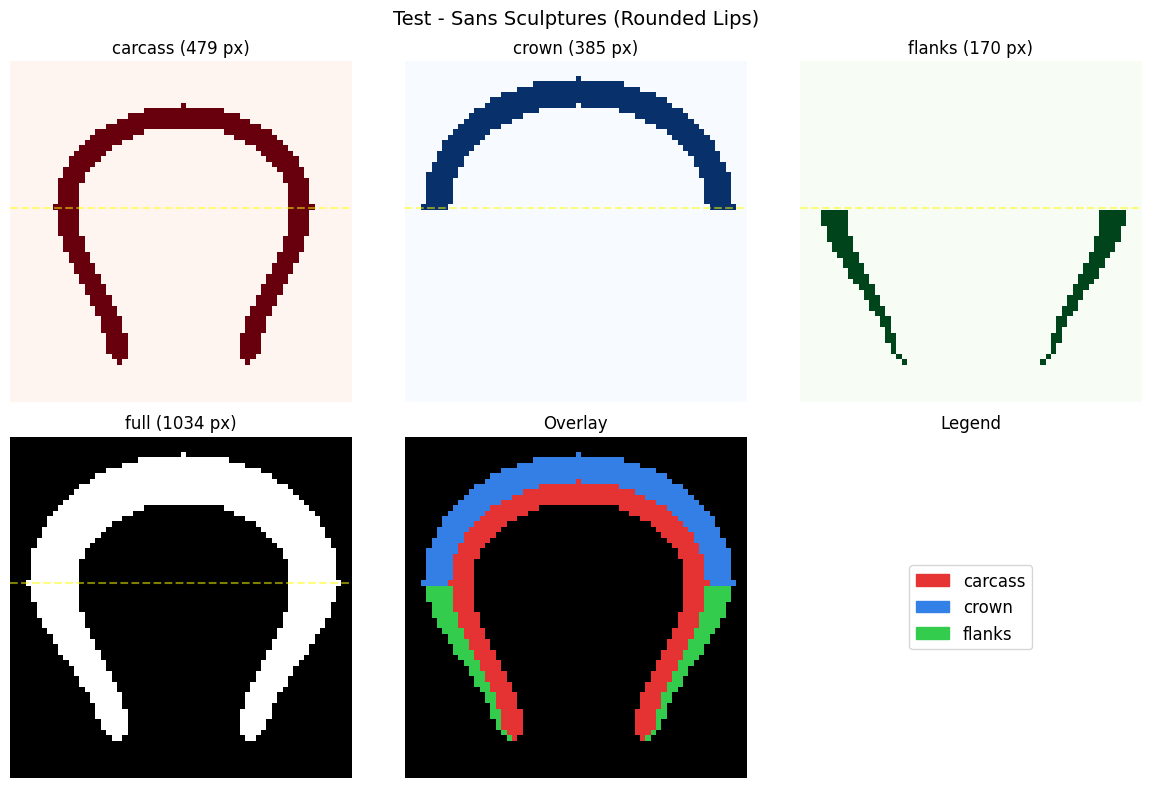

In [9]:
# Test SANS sculptures
test_components = generate_components(
    resolution=64,
    y_top=8,
    y_bottom=56,
    w_belly=24,
    w_bottom=14,
    belly_position=0.40,
    thickness_carcass=4,
    thickness_crown=5,
    thickness_flanks_bottom=1,
    lip_rounding=3,
    add_tread=False
)

valid, errors = validate_components(
    test_components['carcass'],
    test_components['crown'],
    test_components['flanks']
)
print(f"Valid: {valid}")
if errors:
    for e in errors:
        print(f"  - {e}")

visualize_sample(test_components, "Test - Sans Sculptures (Rounded Lips)")

Valid: False


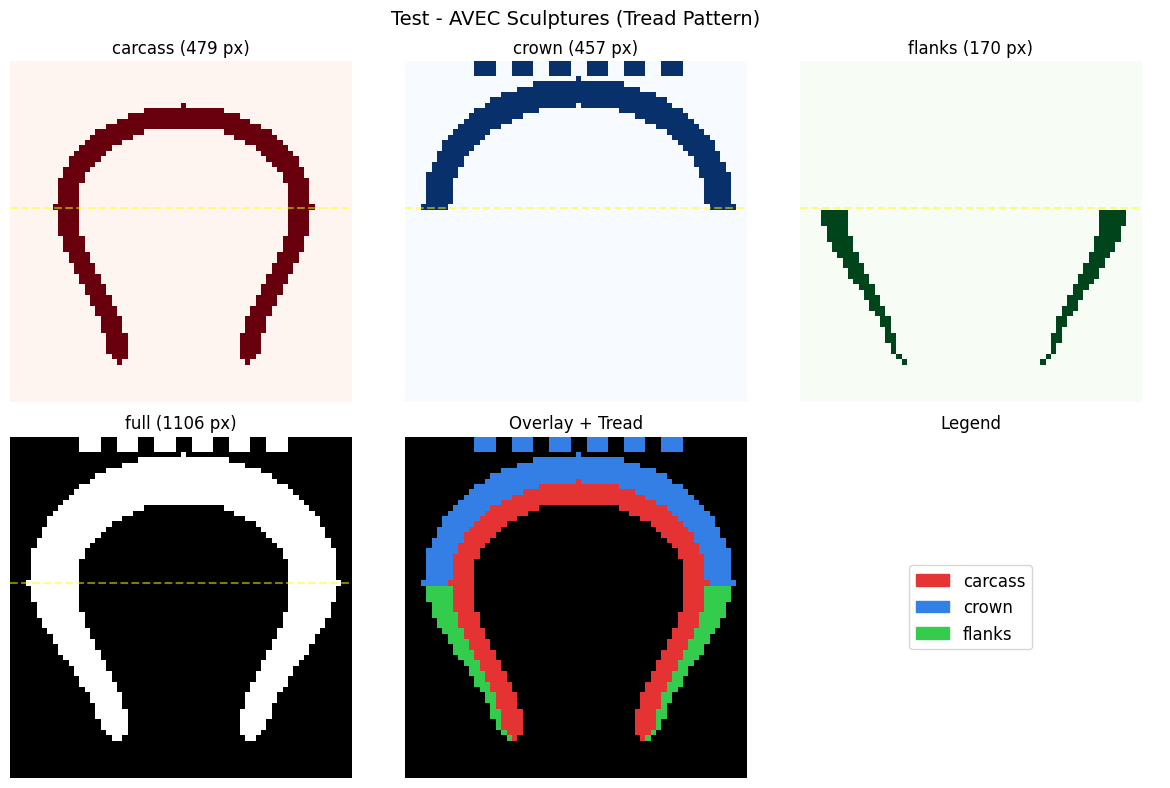

In [10]:
# Test AVEC sculptures
test_with_tread = generate_components(
    resolution=64,
    y_top=8,
    y_bottom=56,
    w_belly=24,
    w_bottom=14,
    belly_position=0.40,
    thickness_carcass=4,
    thickness_crown=5,
    thickness_flanks_bottom=1,
    lip_rounding=3,
    add_tread=True,
    tread_height=3,
    tread_width=4,
    tread_spacing=3,
    n_tread_blocks=6
)

valid, errors = validate_components(
    test_with_tread['carcass'],
    test_with_tread['crown'],
    test_with_tread['flanks']
)
print(f"Valid: {valid}")

visualize_sample(test_with_tread, "Test - AVEC Sculptures (Tread Pattern)")

In [11]:
# Test de la classe TireGeometryMetrics
metrics_evaluator = TireGeometryMetrics()

scores = metrics_evaluator.evaluate(
    test_components['carcass'],
    test_components['crown'],
    test_components['flanks']
)

print(metrics_evaluator.summary(scores))

TIRE GEOMETRY METRICS SUMMARY
✓ overlap_score                 : 1.000
✓ connectivity_score            : 1.000
✓ component_connectivity        : 0.829
✓ symmetry_score                : 0.827
⚠ ellipse_fit_score             : 0.561
✓ vertical_ordering_score       : 1.000
✓ area_ratio_score              : 1.000
⚠ thickness_consistency_score   : 0.505
--------------------------------------------------
✓ GLOBAL SCORE                  : 0.850


In [12]:
# Test avec une "mauvaise" génération (bruit)
np.random.seed(42)
bad_carcass = (np.random.rand(64, 64) > 0.7).astype(np.uint8)
bad_crown = (np.random.rand(64, 64) > 0.8).astype(np.uint8)
bad_flanks = (np.random.rand(64, 64) > 0.85).astype(np.uint8)

bad_scores = metrics_evaluator.evaluate(bad_carcass, bad_crown, bad_flanks)
print("\n" + "="*50)
print("MAUVAISE GÉNÉRATION (bruit aléatoire)")
print("="*50)
print(metrics_evaluator.summary(bad_scores))


MAUVAISE GÉNÉRATION (bruit aléatoire)
TIRE GEOMETRY METRICS SUMMARY
✗ overlap_score                 : 0.122
✗ connectivity_score            : 0.171
✗ component_connectivity        : 0.018
✗ symmetry_score                : 0.354
✗ ellipse_fit_score             : 0.023
✗ vertical_ordering_score       : 0.000
✓ area_ratio_score              : 1.000
⚠ thickness_consistency_score   : 0.795
--------------------------------------------------
✗ GLOBAL SCORE                  : 0.270


## 9. Exploration des paramètres

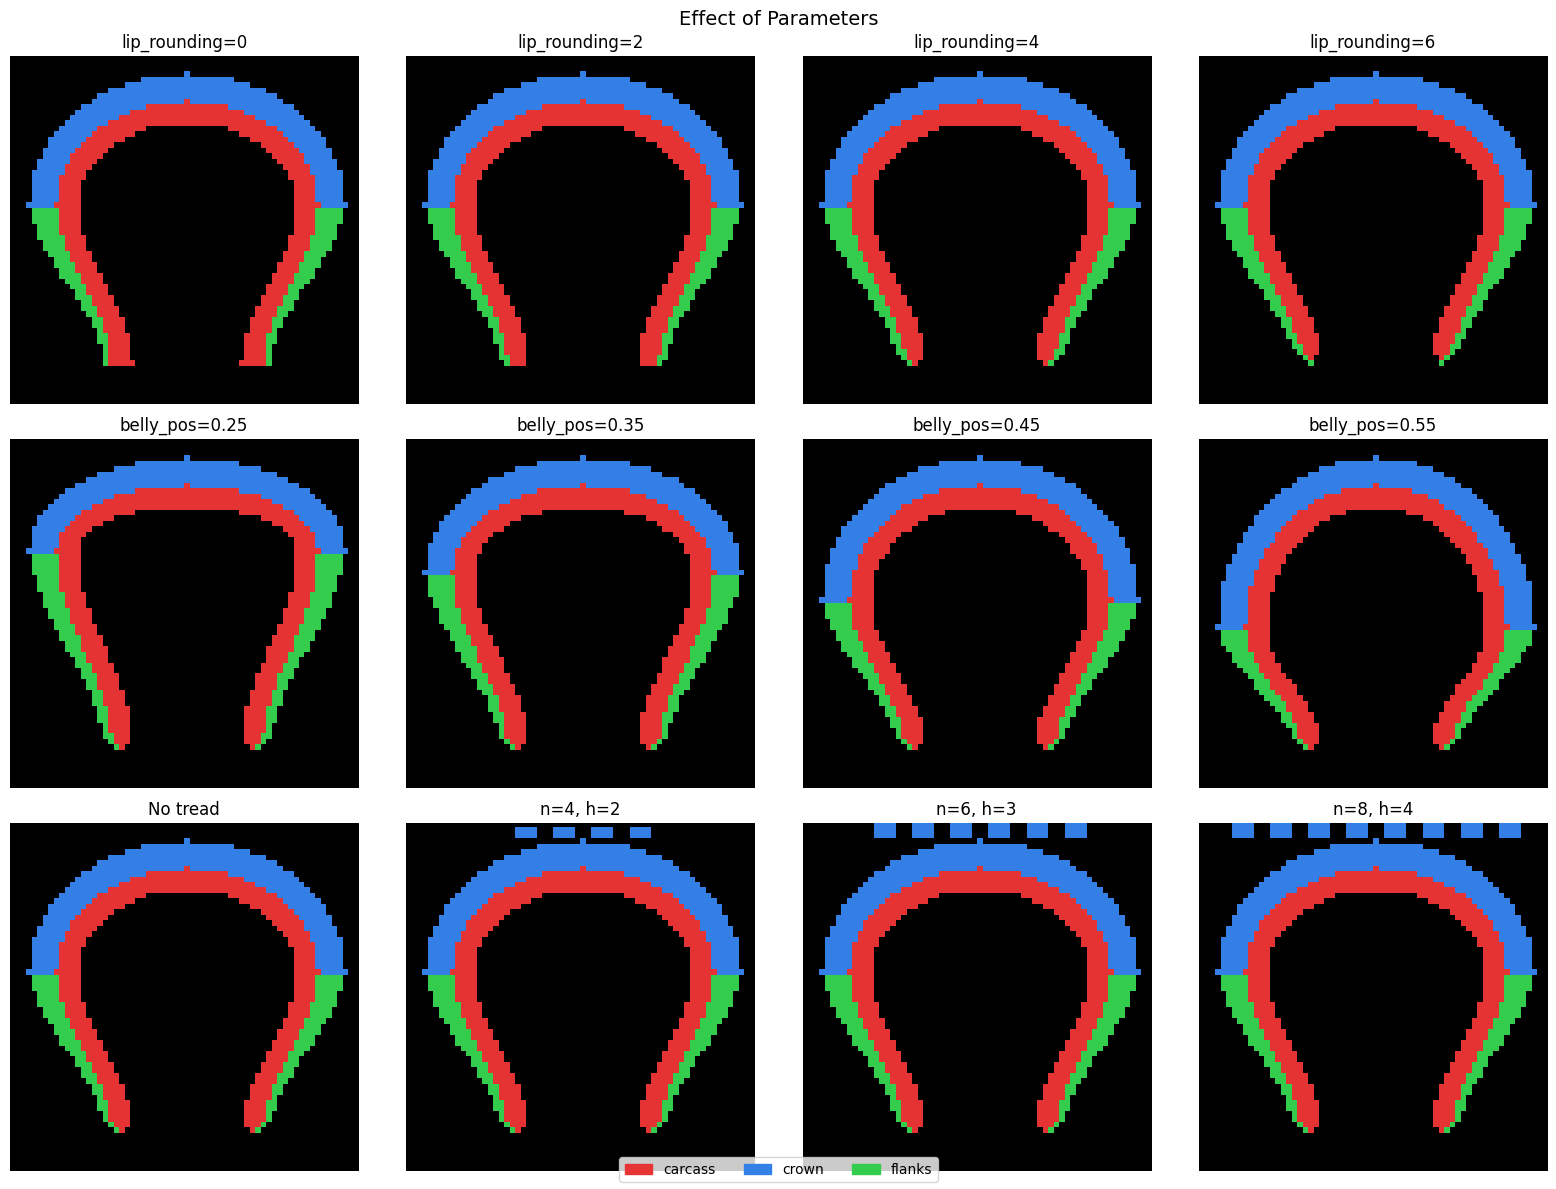

In [13]:
def show_parameter_variations():
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    
    base = dict(resolution=64, y_top=8, y_bottom=56, 
                w_belly=24, w_bottom=14,
                belly_position=0.40, 
                thickness_carcass=4, thickness_crown=5,
                thickness_flanks_bottom=1, lip_rounding=3,
                add_tread=False)
    
    colors = {'carcass': [0.9, 0.2, 0.2], 'crown': [0.2, 0.5, 0.9], 'flanks': [0.2, 0.8, 0.3]}
    
    def make_overlay(comp):
        overlay = np.zeros((64, 64, 3))
        for name, color in colors.items():
            mask = comp[name] > 0
            for c in range(3):
                overlay[:, :, c] += mask * color[c]
        return overlay
    
    # Ligne 1: lip_rounding
    for i, lr in enumerate([0, 2, 4, 6]):
        params = base.copy()
        params['lip_rounding'] = lr
        comp = generate_components(**params)
        axes[0, i].imshow(make_overlay(comp), origin='upper')
        axes[0, i].set_title(f'lip_rounding={lr}')
        axes[0, i].axis('off')
    axes[0, 0].set_ylabel('Lip Rounding', fontsize=12)
    
    # Ligne 2: belly_position
    for i, bp in enumerate([0.25, 0.35, 0.45, 0.55]):
        params = base.copy()
        params['belly_position'] = bp
        comp = generate_components(**params)
        axes[1, i].imshow(make_overlay(comp), origin='upper')
        axes[1, i].set_title(f'belly_pos={bp}')
        axes[1, i].axis('off')
    axes[1, 0].set_ylabel('Belly Position', fontsize=12)
    
    # Ligne 3: avec/sans tread
    tread_configs = [
        {'add_tread': False},
        {'add_tread': True, 'n_tread_blocks': 4, 'tread_height': 2},
        {'add_tread': True, 'n_tread_blocks': 6, 'tread_height': 3},
        {'add_tread': True, 'n_tread_blocks': 8, 'tread_height': 4},
    ]
    for i, tc in enumerate(tread_configs):
        params = base.copy()
        params.update(tc)
        comp = generate_components(**params)
        axes[2, i].imshow(make_overlay(comp), origin='upper')
        title = 'No tread' if not tc['add_tread'] else f"n={tc['n_tread_blocks']}, h={tc['tread_height']}"
        axes[2, i].set_title(title)
        axes[2, i].axis('off')
    axes[2, 0].set_ylabel('Tread Pattern', fontsize=12)
    
    patches = [mpatches.Patch(color=colors[name], label=name) for name in colors]
    fig.legend(handles=patches, loc='lower center', ncol=3)
    
    plt.suptitle('Effect of Parameters', fontsize=14)
    plt.tight_layout()
    plt.show()

show_parameter_variations()

## 10. Génération du dataset

In [14]:
def sample_parameters(config, rng):
    def uniform(r):
        return rng.uniform(r[0], r[1])
    def uniform_int(r):
        return rng.integers(r[0], r[1] + 1)
    
    # Contrainte: thickness_carcass <= thickness_crown
    thickness_crown = uniform_int(config['thickness_crown_range'])
    thickness_carcass = uniform_int([
        config['thickness_carcass_range'][0],
        min(config['thickness_carcass_range'][1], thickness_crown)
    ])
    
    params = {
        'y_top': uniform_int(config['y_top_range']),
        'y_bottom': uniform_int(config['y_bottom_range']),
        'w_belly': uniform_int(config['w_belly_range']),
        'w_bottom': uniform_int(config['w_bottom_range']),
        'belly_position': uniform(config['belly_position_range']),
        'thickness_carcass': thickness_carcass,
        'thickness_crown': thickness_crown,
        'thickness_flanks_bottom': uniform_int(config['thickness_flanks_bottom_range']),
        'lip_rounding': uniform_int(config['lip_rounding_range']),
        'add_tread': config['add_tread'],
    }
    
    if config['add_tread']:
        params.update({
            'tread_height': uniform_int(config['tread_height_range']),
            'tread_width': uniform_int(config['tread_width_range']),
            'tread_spacing': uniform_int(config['tread_spacing_range']),
            'n_tread_blocks': uniform_int(config['n_tread_blocks_range']),
        })
    
    return params


def generate_dataset(config, output_dir, max_retries=10):
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    
    for comp in ['carcass', 'crown', 'flanks', 'full']:
        (output_dir / comp).mkdir(exist_ok=True)
    
    rng = np.random.default_rng(config['seed'])
    
    n_samples = config['n_samples']
    n_train = int(n_samples * config['train_ratio'])
    n_val = int(n_samples * config['val_ratio'])
    
    splits = ['train'] * n_train + ['val'] * n_val + ['test'] * (n_samples - n_train - n_val)
    rng.shuffle(splits)
    
    records = []
    sample_id = 0
    
    pbar = tqdm(total=n_samples, desc="Generating")
    
    while sample_id < n_samples:
        for _ in range(max_retries):
            params = sample_parameters(config, rng)
            
            components = generate_components(
                resolution=config['resolution'],
                **params
            )
            
            valid, _ = validate_components(
                components['carcass'],
                components['crown'],
                components['flanks']
            )
            
            if valid:
                break
        
        if not valid:
            continue
        
        for comp_name in ['carcass', 'crown', 'flanks', 'full']:
            img_path = output_dir / comp_name / f"{sample_id:05d}.png"
            plt.imsave(str(img_path), components[comp_name], cmap='gray')
        
        metrics = compute_metrics(
            components['carcass'],
            components['crown'],
            components['flanks']
        )
        
        record = {
            'sample_id': sample_id,
            'split': splits[sample_id],
            'img_carcass': f"carcass/{sample_id:05d}.png",
            'img_crown': f"crown/{sample_id:05d}.png",
            'img_flanks': f"flanks/{sample_id:05d}.png",
            'img_full': f"full/{sample_id:05d}.png",
            'y_belly': components['y_belly'],
            'has_tread': components.get('has_tread', False),
        }
        
        for k, v in params.items():
            record[f'param_{k}'] = v
        
        if metrics:
            for k, v in metrics.items():
                record[f'metric_{k}'] = v
        
        records.append(record)
        sample_id += 1
        pbar.update(1)
    
    pbar.close()
    
    df = pd.DataFrame(records)
    df.to_csv(output_dir / 'metadata.csv', index=False)
    
    print(f"\n✅ Dataset: {len(df)} samples")
    print(f"   Train: {(df['split'] == 'train').sum()}")
    print(f"   Val: {(df['split'] == 'val').sum()}")
    print(f"   Test: {(df['split'] == 'test').sum()}")
    print(f"   With tread: {df['has_tread'].sum()}")
    
    return df

In [15]:
# Générer dataset SANS sculptures
test_config = CONFIG.copy()
test_config['n_samples'] = 100
test_config['add_tread'] = False

output_dir = './toytire_v7_dataset'
df = generate_dataset(test_config, output_dir)

Generating: 100%|██████████| 100/100 [00:00<00:00, 101.14it/s]


✅ Dataset: 100 samples
   Train: 70
   Val: 15
   Test: 15
   With tread: 0


In [16]:
# Générer dataset AVEC sculptures
test_config_tread = CONFIG.copy()
test_config_tread['n_samples'] = 50
test_config_tread['add_tread'] = True

output_dir_tread = './toytire_v7_tread_dataset'
df_tread = generate_dataset(test_config_tread, output_dir_tread)

Generating: 100%|██████████| 50/50 [00:09<00:00,  5.53it/s]


✅ Dataset: 50 samples
   Train: 35
   Val: 7
   Test: 8
   With tread: 50


## 11. Visualisations

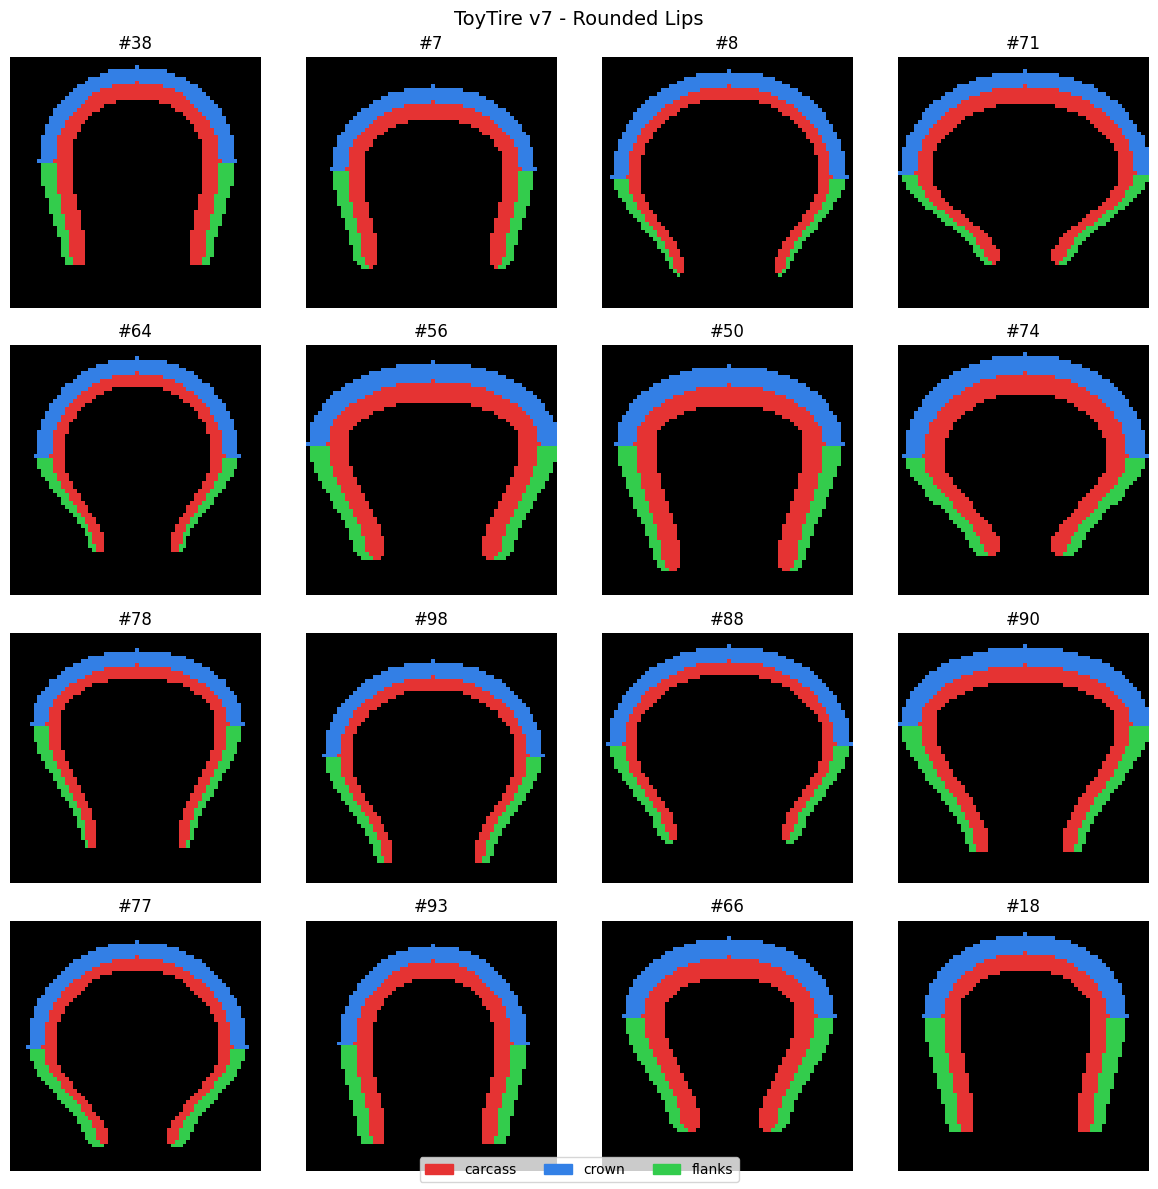

In [17]:
def create_sample_grid(df, output_dir, n_rows=4, n_cols=4):
    output_dir = Path(output_dir)
    rng = np.random.default_rng(42)
    
    n_samples = min(n_rows * n_cols, len(df))
    indices = rng.choice(len(df), n_samples, replace=False)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(3*n_cols, 3*n_rows))
    axes = axes.flatten()
    
    colors = {'carcass': [0.9, 0.2, 0.2], 'crown': [0.2, 0.5, 0.9], 'flanks': [0.2, 0.8, 0.3]}
    
    for ax_idx, idx in enumerate(indices):
        row = df.iloc[idx]
        
        overlay = np.zeros((64, 64, 3))
        for comp in ['carcass', 'crown', 'flanks']:
            img = plt.imread(str(output_dir / row[f'img_{comp}']))
            if len(img.shape) == 3:
                img = img[:, :, 0]
            mask = img > 0.5
            for c in range(3):
                overlay[:, :, c] += mask * colors[comp][c]
        
        axes[ax_idx].imshow(overlay, origin='upper')
        axes[ax_idx].set_title(f"#{row['sample_id']}")
        axes[ax_idx].axis('off')
    
    patches = [mpatches.Patch(color=colors[name], label=name) for name in colors]
    fig.legend(handles=patches, loc='lower center', ncol=3)
    
    plt.suptitle('ToyTire v7 - Rounded Lips', fontsize=14)
    plt.tight_layout()
    plt.savefig(output_dir / 'sample_grid.png', dpi=150, bbox_inches='tight')
    plt.show()

create_sample_grid(df, output_dir)

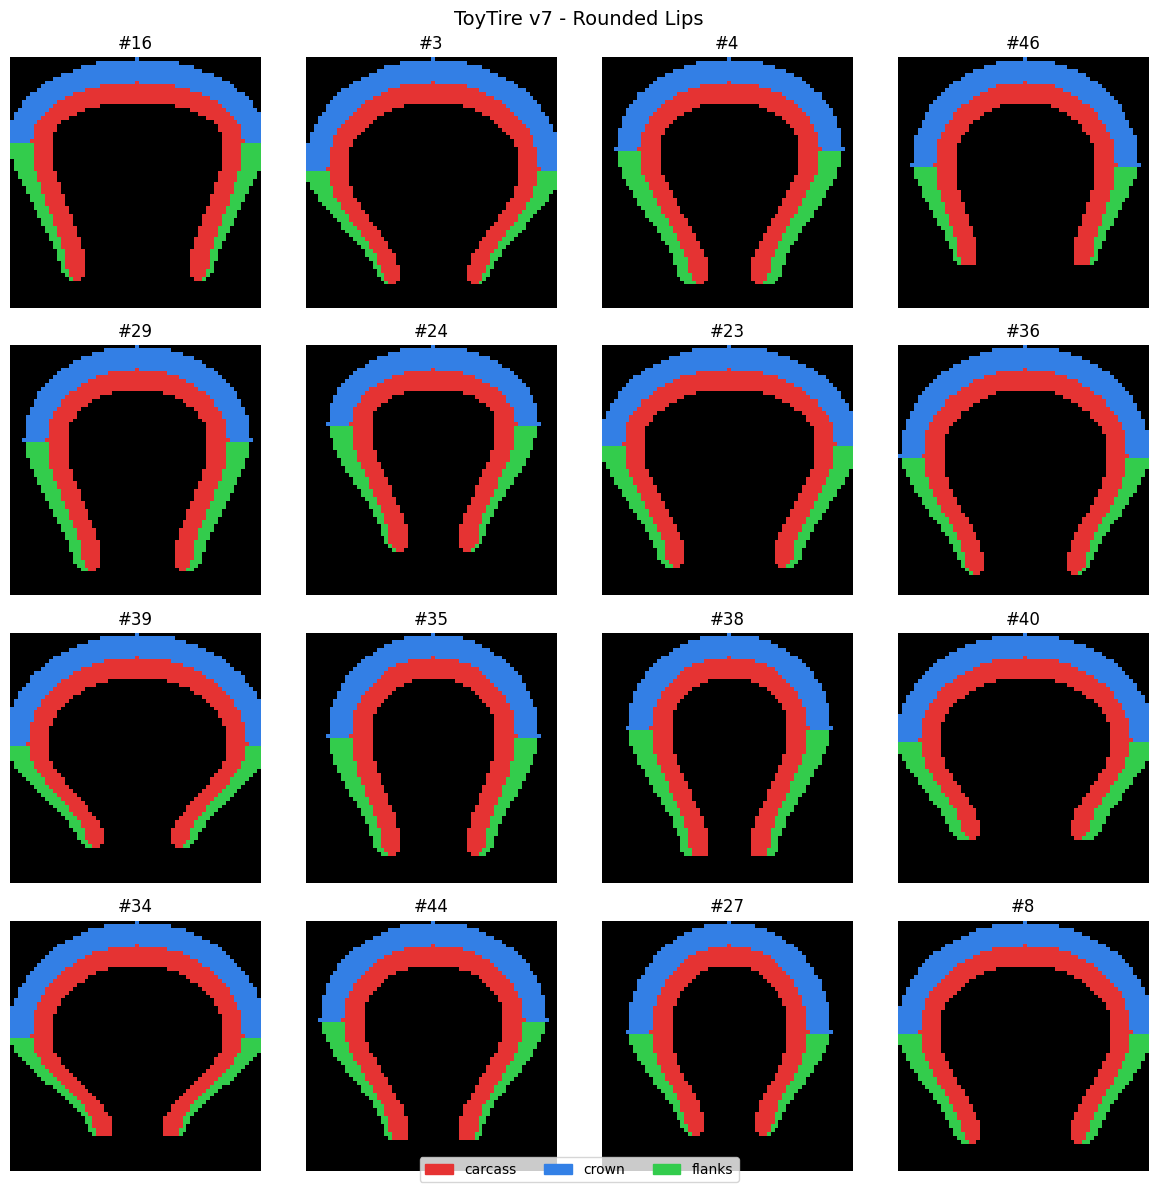

In [18]:
# Grille avec sculptures
create_sample_grid(df_tread, output_dir_tread)

## 12. Évaluation avec TireGeometryMetrics

In [19]:
# Charger quelques échantillons et les évaluer
metrics_evaluator = TireGeometryMetrics()

sample_scores = []

for idx in range(min(20, len(df))):
    row = df.iloc[idx]
    
    carcass = plt.imread(str(Path(output_dir) / row['img_carcass']))
    crown = plt.imread(str(Path(output_dir) / row['img_crown']))
    flanks = plt.imread(str(Path(output_dir) / row['img_flanks']))
    
    if len(carcass.shape) == 3:
        carcass = carcass[:, :, 0]
        crown = crown[:, :, 0]
        flanks = flanks[:, :, 0]
    
    scores = metrics_evaluator.evaluate(carcass, crown, flanks)
    sample_scores.append(scores)

# Statistiques
print("="*50)
print("STATISTIQUES SUR 20 ÉCHANTILLONS")
print("="*50)

for key in sample_scores[0].keys():
    values = [s[key] for s in sample_scores]
    print(f"{key:30s}: mean={np.mean(values):.3f}, std={np.std(values):.3f}")

STATISTIQUES SUR 20 ÉCHANTILLONS
overlap_score                 : mean=1.000, std=0.000
connectivity_score            : mean=1.000, std=0.000
component_connectivity        : mean=0.833, std=0.002
symmetry_score                : mean=0.825, std=0.025
ellipse_fit_score             : mean=0.517, std=0.075
vertical_ordering_score       : mean=1.000, std=0.000
area_ratio_score              : mean=0.998, std=0.006
thickness_consistency_score   : mean=0.478, std=0.067
global_score                  : mean=0.841, std=0.018


## 13. DataLoader

In [20]:
class ToyTireDataset:
    def __init__(self, data_dir, split='train'):
        self.data_dir = Path(data_dir)
        self.df = pd.read_csv(self.data_dir / 'metadata.csv')
        self.df = self.df[self.df['split'] == split].reset_index(drop=True)
        self.components = ['carcass', 'crown', 'flanks']
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        imgs = []
        for comp in self.components:
            img = plt.imread(str(self.data_dir / row[f'img_{comp}']))
            if len(img.shape) == 3:
                img = img[:, :, 0]
            imgs.append((img > 0.5).astype(np.float32))
        
        return {
            'components': np.stack(imgs, axis=0),
            'sample_id': row['sample_id'],
            'has_tread': row.get('has_tread', False)
        }

dataset = ToyTireDataset(output_dir, split='train')
print(f"Dataset size: {len(dataset)}")
print(f"Sample shape: {dataset[0]['components'].shape}")

Dataset size: 70
Sample shape: (3, 64, 64)


---

## 📋 Résumé v7

### Nouvelles fonctionnalités :

1. **Extrémités arrondies** (`lip_rounding`) : Les lèvres de la carcasse sont maintenant courbées comme la bouche d'un vase

2. **Sculptures optionnelles** (`add_tread=True`) : Blocs rectangulaires sur le sommet de la couronne

3. **Contrainte d'épaisseur** : `thickness_carcass <= thickness_crown` est toujours respecté

4. **TireGeometryMetrics** : Classe pour évaluer les générations

### Utilisation de TireGeometryMetrics :

```python
from tire_metrics import TireGeometryMetrics

# Initialiser l'évaluateur
evaluator = TireGeometryMetrics()

# Évaluer une génération
scores = evaluator.evaluate(generated_carcass, generated_crown, generated_flanks)

# Score global (0-1, 1 = parfait)
print(f"Quality: {scores['global_score']:.3f}")

# Évaluer un batch
batch_scores = evaluator.evaluate_batch(carcass_batch, crown_batch, flanks_batch)
print(f"Mean quality: {batch_scores['global_score'].mean():.3f}")
```